# Proyek Klasifikasi Gambar: Smoker Detection
- **Nama:** Nabilla Salsa Billa
- **Email:** nsalshabila15@gmail.com
- **ID Dicoding:** nbilasals

## Import Semua Packages/Library yang Digunakan

In [2]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator as IDG
import os
import shutil
import matplotlib.pyplot as plt
from google.colab import files
from PIL import Image
import os
import random
import shutil
import os
import random
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
import numpy as np
import cv2
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

## Data Preparation

### Data Loading

In [2]:
uploaded = files.upload()

# Move kaggle.json to the Kaggle folder and set permissions
if 'kaggle.json' in uploaded:
    !mkdir -p ~/.kaggle
    shutil.move('kaggle.json', '~/.kaggle/kaggle.json')
    !chmod 600 ~/.kaggle/kaggle.json
    print("kaggle.json has been uploaded and configured successfully.")
else:
    print("kaggle.json file not uploaded. Please try again.")


Saving kaggle.json to kaggle.json


FileNotFoundError: [Errno 2] No such file or directory: '~/.kaggle/kaggle.json'

In [3]:
!kaggle datasets download -d sujaykapadnis/smoking

Dataset URL: https://www.kaggle.com/datasets/sujaykapadnis/smoking
License(s): Attribution 4.0 International (CC BY 4.0)
 94% 60.0M/63.8M [00:02<00:00, 31.8MB/s]
100% 63.8M/63.8M [00:02<00:00, 26.1MB/s]


In [4]:
!unzip smoking.zip

Archive:  smoking.zip
  inflating: Testing/Testing/notsmoking_0004.jpg  
  inflating: Testing/Testing/notsmoking_0014.jpg  
  inflating: Testing/Testing/notsmoking_0018.jpg  
  inflating: Testing/Testing/notsmoking_0026.jpg  
  inflating: Testing/Testing/notsmoking_0032.jpg  
  inflating: Testing/Testing/notsmoking_0036.jpg  
  inflating: Testing/Testing/notsmoking_0041.jpg  
  inflating: Testing/Testing/notsmoking_0049.jpg  
  inflating: Testing/Testing/notsmoking_0053.jpg  
  inflating: Testing/Testing/notsmoking_0058.jpg  
  inflating: Testing/Testing/notsmoking_0062.jpg  
  inflating: Testing/Testing/notsmoking_0069.jpg  
  inflating: Testing/Testing/notsmoking_0075.jpg  
  inflating: Testing/Testing/notsmoking_0081.jpg  
  inflating: Testing/Testing/notsmoking_0085.jpg  
  inflating: Testing/Testing/notsmoking_0091.jpg  
  inflating: Testing/Testing/notsmoking_0095.jpg  
  inflating: Testing/Testing/notsmoking_0104.jpg  
  inflating: Testing/Testing/notsmoking_0107.jpg  
  inflati

### Training and Testing Splitting

In this notebook, we do data splitting first because we won't do any data augmentation to testing data

In [ ]:
!ls

kaggle.json  sample_data  smoking.zip  Testing	Training  Validation


In [5]:
train_path = 'Training/Training'
test_path = 'Testing/Testing'
validation_path = 'Validation/Validation'
paths = [train_path, test_path, validation_path]
for path in paths:
    print(path)
    if not os.path.exists(os.path.join(path, 'Smoking')):
        os.makedirs(os.path.join(path, 'Smoking'))
    if not os.path.exists(os.path.join(path, 'NotSmoking')):
        os.makedirs(os.path.join(path, 'NotSmoking'))
    for i in os.listdir(path):
        if os.path.isfile(os.path.join(path, i)):
            if i[:7] == 'smoking':
                os.rename(os.path.join(path, i), os.path.join(path, 'Smoking', i))
            else:
                os.rename(os.path.join(path, i), os.path.join(path, 'NotSmoking', i))

Training/Training
Testing/Testing
Validation/Validation


In [6]:
combined_path = 'CombinedDataset'
final_train_path = 'Training/Training'
final_test_path = 'Testing/Testing'

categories = ['Smoking', 'NotSmoking']

In [7]:
# Step 1: Combine both Smoking and NotSmoking from training and testing into one combined directory
if not os.path.exists(combined_path):
    os.makedirs(combined_path)

for category in categories:
    for path in [train_path, test_path]:
        source_dir = os.path.join(path, category)
        destination_dir = os.path.join(combined_path, category)
        if not os.path.exists(destination_dir):
            os.makedirs(destination_dir)
        # Move images from the current directories to the combined directory
        for img in os.listdir(source_dir):
            shutil.move(os.path.join(source_dir, img), os.path.join(destination_dir, img))

In [8]:
# Step 2: Get all image paths in the combined dataset
all_smoking_images = os.listdir(os.path.join(combined_path, 'Smoking'))
all_notsmoking_images = os.listdir(os.path.join(combined_path, 'NotSmoking'))

# Shuffle the images
random.shuffle(all_smoking_images)
random.shuffle(all_notsmoking_images)

In [9]:
# Step 3: Determine the 80:20 split
train_smoking_count = int(0.8 * len(all_smoking_images))
train_notsmoking_count = int(0.8 * len(all_notsmoking_images))

In [10]:
# Step 4: Move 80% of images to Training and the rest to Testing
for category, images, train_count in zip(categories, [all_smoking_images, all_notsmoking_images], [train_smoking_count, train_notsmoking_count]):
    # Training images
    for img in images[:train_count]:
        shutil.move(os.path.join(combined_path, category, img), os.path.join(final_train_path, category, img))
    # Testing images
    for img in images[train_count:]:
        shutil.move(os.path.join(combined_path, category, img), os.path.join(final_test_path, category, img))

In [11]:
# Function to count images in each category and print the results
def count_images(path):
    counts = {}
    for category in categories:
        category_path = os.path.join(path, category)
        if os.path.exists(category_path):
            counts[category] = len(os.listdir(category_path))
        else:
            counts[category] = 0
    return counts

# Counting images in Training and Testing sets
train_counts = count_images(final_train_path)
test_counts = count_images(final_test_path)

# Printing the number of images in each category
print("Training set:")
for category in categories:
    print(f"{category}: {train_counts[category]} images")

print("\nTesting set:")
for category in categories:
    print(f"{category}: {test_counts[category]} images")

Training set:
Smoking: 376 images
NotSmoking: 376 images

Testing set:
Smoking: 94 images
NotSmoking: 94 images


Preview Some Images


Displaying samples from: Training/Training


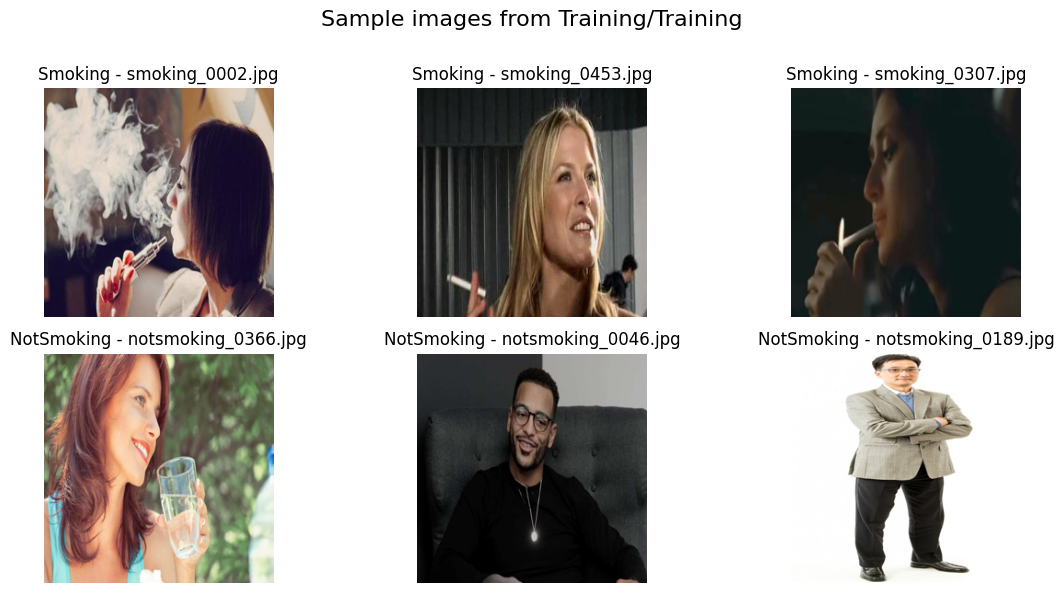


Displaying samples from: Testing/Testing


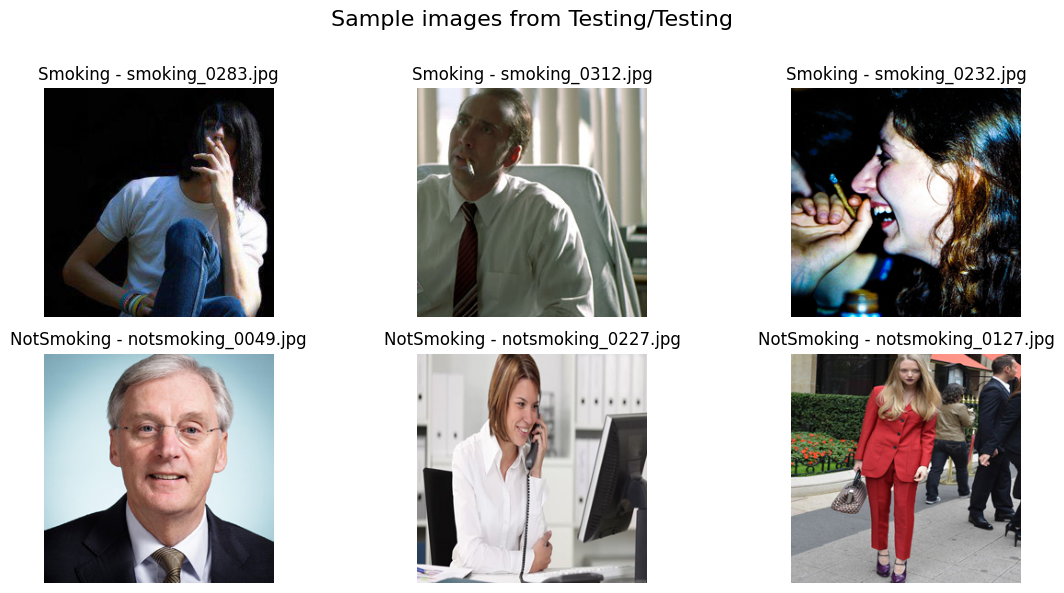


Displaying samples from: Validation/Validation


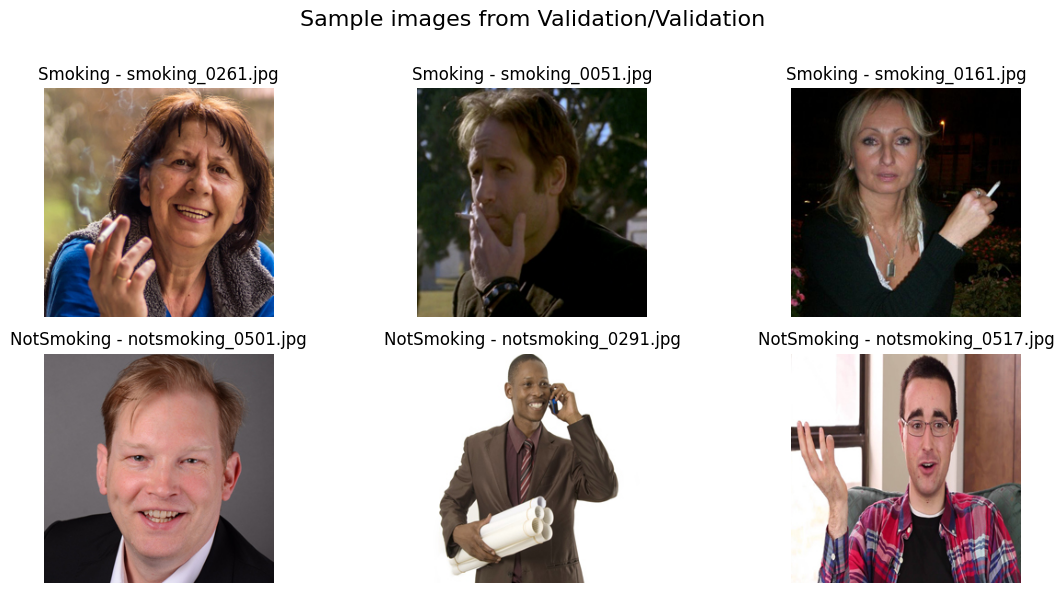

In [12]:
allowed_formats = ('.jpg', '.jpeg', '.png', '.bmp', '.gif')

def display_sample_images(paths, categories, sample_count=3):
    for path in paths:
        print(f"\nDisplaying samples from: {path}")
        fig, axes = plt.subplots(len(categories), sample_count, figsize=(12, 6))
        fig.suptitle(f"Sample images from {path}", fontsize=16)

        for idx, category in enumerate(categories):
            category_path = os.path.join(path, category)
            if os.path.exists(category_path):
                images = [img for img in os.listdir(category_path) if img.endswith(allowed_formats)]

                for i in range(min(sample_count, len(images))):
                    img_path = os.path.join(category_path, images[i])
                    try:
                        img = Image.open(img_path)
                        ax = axes[idx, i] if sample_count > 1 else axes[idx]
                        ax.imshow(img)
                        ax.axis('off')
                        ax.set_title(f"{category} - {images[i]}")
                    except Exception as e:
                        print(f"Error opening image {img_path}: {e}")
                        if sample_count > 1:
                            axes[idx, i].axis('off')
                        else:
                            axes[idx].axis('off')
            else:
                print(f"Category folder '{category}' not found in {path}.")
                for i in range(sample_count):
                    if sample_count > 1:
                        axes[idx, i].axis('off')
                    else:
                        axes[idx].axis('off')

        plt.tight_layout()
        plt.subplots_adjust(top=0.85)
        plt.show()

# Display sample images
display_sample_images(paths, categories, sample_count=3)

## Data Preprocessing

In [7]:
# Set up ImageDataGenerator for training and validation with the split
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
)

# Set up ImageDataGenerator for testing (no augmentation)
test_datagen = ImageDataGenerator(rescale=1./255)

# Flow from directory for training (with augmentations)
train_generator = train_datagen.flow_from_directory(
    'Training/Training',  # Folder for training data
    target_size=(251, 251),
    batch_size=32,
    class_mode='binary',
)

# Flow from directory for validation (use the 'Validation' folder directly)
validation_generator = test_datagen.flow_from_directory(
    'Validation/Validation',  # Folder for validation data
    target_size=(251, 251),
    batch_size=32,
    class_mode='binary'
)

# Flow from directory for testing (no augmentations)
test_generator = test_datagen.flow_from_directory(
    'Testing/Testing',  # Folder for testing data
    target_size=(251, 251),
    batch_size=32,
    class_mode='binary'
)

Found 752 images belonging to 2 classes.
Found 180 images belonging to 2 classes.
Found 188 images belonging to 2 classes.


## Modelling

In [31]:
cnn = tf.keras.models.Sequential([
    # Input Layer
    tf.keras.layers.Conv2D(filters=64, kernel_size=3, activation="relu", input_shape=[251, 251, 3]),
    tf.keras.layers.MaxPool2D(pool_size=2, strides=2),
    tf.keras.layers.BatchNormalization(),

    # Second Convolutional Block
    tf.keras.layers.Conv2D(filters=128, kernel_size=3, activation="relu"),
    tf.keras.layers.MaxPool2D(pool_size=2, strides=2),
    tf.keras.layers.BatchNormalization(),

    # Third Convolutional Block
    tf.keras.layers.Conv2D(filters=256, kernel_size=3, activation="relu"),
    tf.keras.layers.MaxPool2D(pool_size=2, strides=2),
    tf.keras.layers.BatchNormalization(),

    # Flatten the output for the fully connected layers
    tf.keras.layers.Flatten(),

    # Fully Connected Layer
    tf.keras.layers.Dense(units=512, activation="relu"),
    tf.keras.layers.Dropout(0.5),  # Regularization

    # Output Layer (Binary classification)
    tf.keras.layers.Dense(units=1, activation="sigmoid")
])

# Compile the model
cnn.compile(optimizer="Adam", loss="binary_crossentropy", metrics=['accuracy'])

# Display model summary
cnn.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_15 (Conv2D)                   │ (None, 249, 249, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_15 (MaxPooling2D)      │ (None, 124, 124, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_12               │ (None, 124, 124, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_16 (Conv2D)                   │ (None, 122, 122, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_16 (MaxPooling2D)      │ (None, 61, 61, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_13               │ (None, 61, 61, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_17 (Conv2D)                   │ (None, 59, 59, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_17 (MaxPooling2D)      │ (None, 29, 29, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_14               │ (None, 29, 29, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_5 (Flatten)                  │ (None, 215296)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 512)                 │     110,232,064 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 1)                   │             513 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 110,605,185 (421.93 MB)

 Trainable params: 110,604,289 (421.92 MB)

 Non-trainable params: 896 (3.50 KB)

In [32]:
# EarlyStopping callback to stop training
early_stopping = EarlyStopping(monitor='val_accuracy',
                               patience=10,  # Stop after 10 epochs if no improvement
                               min_delta=0.01,  # Minimum change to qualify as an improvement
                               mode='max',  # Maximize validation accuracy
                               verbose=1,  # Display messages when training stops
                               restore_best_weights=True)  # Restore the best weights when stopped

# Train the model with the data generators
history = cnn.fit(
    train_generator,  # Training data generator
    epochs=100,  # Set a higher number of epochs
    validation_data=validation_generator,  # Validation data generator
    callbacks=[early_stopping]  # Include the EarlyStopping callback
)

Epoch 1/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 24s 635ms/step - accuracy: 0.5955 - loss: 34.0767 - val_accuracy: 0.7222 - val_loss: 6.5522
Epoch 2/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 14s 446ms/step - accuracy: 0.6593 - loss: 25.6127 - val_accuracy: 0.6833 - val_loss: 8.3558
Epoch 3/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 20s 396ms/step - accuracy: 0.7073 - loss: 15.8230 - val_accuracy: 0.6944 - val_loss: 5.7481
Epoch 4/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 14s 423ms/step - accuracy: 0.7088 - loss: 13.0428 - val_accuracy: 0.4944 - val_loss: 14.0381
Epoch 5/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 13s 426ms/step - accuracy: 0.7255 - loss: 10.2488 - val_accuracy: 0.3611 - val_loss: 13.3581
Epoch 6/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 13s 421ms/step - accuracy: 0.7566 - loss: 4.9020 - val_accuracy: 0.5389 - val_loss: 7.5942
Epoch 7/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 21s 381ms/step - accuracy: 0.7216 - loss: 6.2351 - val_accuracy: 0.7222 - val_loss: 3.0957
Epoch 8/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 20s 438ms/step - accuracy: 0.7827 - loss: 3.

## Evaluasi dan Visualisasi

In [33]:
test_loss, test_accuracy = cnn.evaluate(test_generator)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 812ms/step - accuracy: 0.7542 - loss: 6.7371
Test Loss: 7.069551467895508
Test Accuracy: 0.7127659320831299


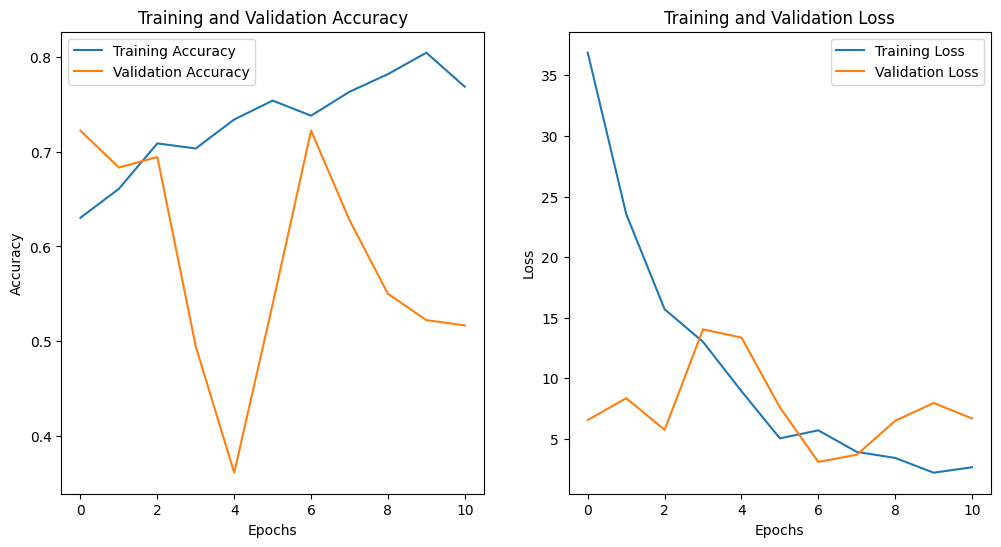

In [34]:
# Plotting accuracy and loss
def plot_metrics(history):
    # Plot accuracy
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

# Call the function to plot accuracy and loss
plot_metrics(history)

We'll try to use Transfer Learning

In [5]:
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras import layers, models

# Load pre-trained InceptionV3 model without the top layer (for feature extraction)
base_model = InceptionV3(input_shape=(251, 251, 3), include_top=False, weights='imagenet')

# Freeze the base model to prevent its weights from being updated during training
base_model.trainable = False

# Build a custom Sequential model on top of the pre-trained model
model = models.Sequential([
    base_model,  # Add the InceptionV3 base model
    layers.GlobalAveragePooling2D(),  # Pooling layer after the base model
    layers.Dense(128, activation='relu'),  # Add a dense layer
    layers.Dense(1, activation='sigmoid')  # Output layer for binary classification
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [8]:
# EarlyStopping callback to stop training
early_stopping = EarlyStopping(monitor='val_accuracy',
                               patience=10,  # Stop after 10 epochs if no improvement
                               min_delta=0.01,  # Minimum change to qualify as an improvement
                               mode='max',  # Maximize validation accuracy
                               verbose=1,  # Display messages when training stops
                               restore_best_weights=True)  # Restore the best weights when stopped

# Train the model with the data generators
history = model.fit(
    train_generator,  # Training data generator
    epochs=100,  # Set a higher number of epochs
    validation_data=validation_generator,  # Validation data generator
    callbacks=[early_stopping]  # Include the EarlyStopping callback
)

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 51s 1s/step - accuracy: 0.5329 - loss: 1.1776 - val_accuracy: 0.9000 - val_loss: 0.3796
Epoch 2/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 12s 517ms/step - accuracy: 0.8731 - loss: 0.3877 - val_accuracy: 0.9056 - val_loss: 0.2586
Epoch 3/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 13s 547ms/step - accuracy: 0.8808 - loss: 0.2967 - val_accuracy: 0.9222 - val_loss: 0.2098
Epoch 4/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 13s 523ms/step - accuracy: 0.8823 - loss: 0.3003 - val_accuracy: 0.9167 - val_loss: 0.1890
Epoch 5/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 14s 573ms/step - accuracy: 0.8991 - loss: 0.2254 - val_accuracy: 0.9167 - val_loss: 0.1840
Epoch 6/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 12s 522ms/step - accuracy: 0.9026 - loss: 0.2162 - val_accuracy: 0.9222 - val_loss: 0.1892
Epoch 7/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 12s 517ms/step - accuracy: 0.9273 - loss: 0.1857 - val_accuracy: 0.9278 - val_loss: 0.1675
Epoch 8/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 13s 525ms/step - accuracy: 0.9167 - loss: 0.2004 - val

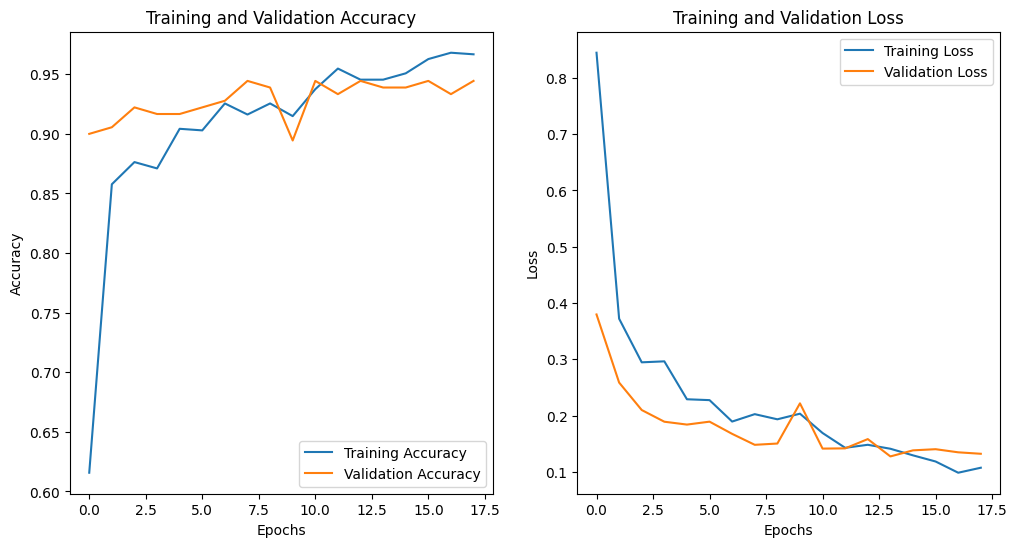

In [9]:
# Plotting accuracy and loss
def plot_metrics(history):
    # Plot accuracy
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

# Call the function to plot accuracy and loss
plot_metrics(history)

## Konversi Model

In [38]:
!pip install tensorflowjs

INFO: pip is looking at multiple versions of tf-keras to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.9/15.9 MB 85.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 615.3/615.3 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 75.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 62.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 105.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.3/9.3 MB 113.5 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 24.2
    Uninstalling packaging-24.2:
      Successfully uninstalled packaging-24.2
  Attempting uninstall: tensorboard
    Found existing installation: 

In [39]:
import os
os.makedirs("submission/tfjs_model", exist_ok=True)
os.makedirs("submission/tflite", exist_ok=True)
os.makedirs("submission/saved_model", exist_ok=True)


In [40]:
# Menyimpan model dalam format SavedModel
save_path = 'submission/saved_model/'
tf.saved_model.save(model, save_path)

Cause: Unable to locate the source code of <function TFLayer._default_save_signature.<locals>.serving_default at 0x7afbc3b913f0>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: lineno is out of bounds
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: Unable to locate the source code of <function TFLayer._default_save_signature.<locals>.serving_default at 0x7afbc3b913f0>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: lineno is out of bounds
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: Unable to locate the source code of <function TFLayer._default_save_signature.<locals>.serving_default at 0x7afb841ed240>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: lineno is out of bounds
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: Unable to locate the source code of <function TFLayer._default_save_signature.<locals>.serving_default at 0x7afb841ed240>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: lineno is out of bounds
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: Unable to locate the source code of <function TFLayer._default_save_signature.<locals>.serving_default at 0x7afb841eeb00>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: lineno is out of bounds
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: Unable to locate the source code of <function TFLayer._default_save_signature.<locals>.serving_default at 0x7afb841eeb00>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: lineno is out of bounds
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


In [3]:
# Konversi model ke format TFLite
converter = tf.lite.TFLiteConverter.from_saved_model("submission/saved_model")
tflite_model = converter.convert()

# Simpan model TFLite
with open("submission/tflite/model.tflite", "wb") as f:
    f.write(tflite_model)


In [10]:
import tensorflowjs as tfjs

# Simpan model ke format TensorFlow.js
tfjs.converters.save_keras_model(model, "submission/tfjs_model")

failed to lookup keras version from the file,
    this is likely a weight only file


In [11]:
import shutil
from google.colab import files

# Zip the folder
shutil.make_archive('/content/submission', 'zip', '/content/submission')

# Download the zip file
files.download('/content/submission.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Inference (Optional)